## Create Cost Stack 
This code reads in a **table of biogas sources** -- including coordinates, estimated methane production costs (`$/MMBtu`), and pipeline delivery costs (`$/mi-MMBtu @15y`) -- and a **raster cost surface**, with units of mulitpliers (in percent) applied to building a section of pipeline through that cell. 

The code iterates through each biogas source and develops a least cost distance surface away from that source such that each pixel's value represents the aggregate cost to deliver 1 MMbtu of methane and to that pixel's location. The result is a stack of these cost distance surfaces, one for each biogas source. 

The minimum value from the set of all cost distance surfaces represents the minimum cost to deliver methane to that site (from any source). It can be thresholded (select all cells below a set minimum cost) to identify all areas that are cost effective to connect at a set price point. This would also identify other biogas sources that, alone, are not cost effective, but when considered alongside other sites, become cost effective. 

This notebook also saves both the stack of cost surfaces and cost distances surfaces to numpy export files (`DuplinCostStack.npy` and `DuplinStack.npy`, respectively). These are used in later notebooks that carry the analysis forward.


Summer 2019, john.fay@duke.edu

#### 1. Load packages
The Conda environment required to run this script is provided in the project root folder: [`bg_optimi.yml`](https://raw.githubusercontent.com/johnpfay/BioGas_optimization/master/bg_optimi.yml). 

In [2]:
#Import packages
import os                                   # operating system utilities
import numpy as np                          # to process arrays
import pandas as pd                         # to process data frames
from skimage import graph                   # to compute least cost paths
from osgeo import gdal                      # to process spatially referenced rasters
import geopandas as gpd                     # to process geo-data frames
from shapely.geometry import Point          # to process spatial features
#Plotting packages
import matplotlib.pyplot as plt             # to construct figures
from matplotlib import cm                   # colormaps for figures
from mpl_toolkits.mplot3d import Axes3D     # to construct 3d figures

#### 2. Read in the cost surface
The cost surface is a georeferenced raster (`img` format). Here, we read the file into a gdal data source object, from which we extract the file's projection (`ds_prj`) and its affine transformation parameters (lower left coordinate, angle, and pixel size).

The original raster here are in percentage values so we divide by 100 to convert to decimal values.

In [3]:
#Read in cost surface data source
ds =  gdal.Open('../data/MIT_Surface_Subset/MIT_CostSurface_500m.img')
#Get the raster projection
ds_prj = ds.GetProjection()
#Get raster attributes
llx, x_size, x_angle, lly, y_angle, y_size = ds.GetGeoTransform()
#Extract Band1 as the cost array; divide by 100 to scale as a percentage
arrCost = np.array(ds.GetRasterBand(1).ReadAsArray()) / 100
#Print info
print("Lower left coordinate = ({0:.8f},{1:.8f})".format(llx,lly))
print("Pixel size is {0:.1f}(x), {1:.1f}(y)".format(x_size,y_size))
print("Values range from {} to {}".format(arrCost.min(),arrCost.max()))

Lower left coordinate = (1502530.32985527,-361423.20573852)
Pixel size is 500.0(x), -500.0(y)
Values range from 0.0 to 3.0


Null [NoData] values in the input are areas of infinite costs. The algorithm used to compute LCPs doesn't like null values, so we conver them to exceedingly high values (the max cost raised an order of magnitude) to mimic the same effect. 

In [4]:
#Set zero cost multiplier to high costs (max X 10)
arrCost[arrCost == 0] = arrCost.max() * 10

#### 3. Read in the biogas source data
Here, we read in the biogas source data, held in an Excel worksheet called `Duplin County Swine Farm Master` in the Excel file called `DuplinCountySwineFarmEconomics.xlsx`. Instead of reading in all columns, we just read in select columns (ones indexed at 11,12,17,19,22).

Once imported, we sort the table on cost ($/mi-MMBtu @15y) so that least cost biogas sources are evaluated first. This shouldn't affect the analysis to compute the overall minimum, but it's helpful for reviewing the results. 

In [5]:
#Read in biogas sources (example: Duplin Co)
dfBG =  pd.read_excel('../data/DuplinCountySwineFarmEconomics.xlsx',
                         sheet_name='Duplin County Swine Farm Master').iloc[:,[11,12,17,19,22]]
#Sort values in ascending order by cost to pipe
dfBG.sort_values(by='TEST ($/mi-MMBtu @15y)',ascending=True,inplace=True)
#Display the first 5 rows of data
dfBG.head()

,Farm Latitude,Farm Longitude,Total Potential Methane Yield (scf/h),Estimated Methane Production Cost ($/MMBtu),TEST ($/mi-MMBtu @15y)
141,34.8672,-78.1514,5450.830387,2.332976,0.019108
197,34.9131,-77.9531,5237.045262,2.630236,0.019736
163,34.8825,-78.1094,4274.978908,4.138270,0.023257
202,34.9228,-77.9597,3038.314870,6.675278,0.030653
55,34.7806,-78.1694,2948.403709,6.898455,0.031406


We'll need to align these point features, referenced to a geographic coordinate system, to the array coordinates (row and column values), and thus we'll have to project these data to the same coordinate system used by the cost surface. 

The first step in this is to convert the raw data to geographic features, done by converting the dataframe to a geopandas geo-dataframe and defining its coordinate reference system ([4269](https://spatialreference.org/ref/epsg/4269/) is NAD 83 geographic coordinate system)

In [6]:
#Convert to a geopandas dataframe (for easy reprojecting)
geom = [Point(xy) for xy in zip(dfBG.iloc[:,1],dfBG.iloc[:,0])] #Create the geometry objects
gdfBG = gpd.GeoDataFrame(dfBG, geometry = geom)                 #Convert to a geodataframe
gdfBG.crs = {'init':'epsg:4269'}                                #Set the projection (NAD 1983)
#gdfBG.to_file('../data/DuplinSites_LL.shp')                     #Save to a file

Now we can re-project these point features to the same coordinate system as the cost surface. (Or if the reprojected file already exists, we can read that file in and save some time). We'll also include new fields to store the x- and y-offsets, i.e., the column and row references used to link the features to the image as an array. 

In [7]:
#Re-project the points to match the raster (takes a moment...)
projFeaturesFilename = '../data/DuplinSites_Prj.shp'
if os.path.exists(projFeaturesFilename):
    print("Using existing file.")
    gdfBG_prj = gpd.read_file(projFeaturesFilename) 
else:
    print("Reprojecting data",end='')
    #Create the CRS matching the input raster (lookup https://spatialreference.org/ref/esri/102010/)
    outCRS = {'proj': 'eqdc', 'lat_0': 40, 'lon_0': -96, 'lat_1': 20, 'lat_2': 60, 
              'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}
    gdfBG_prj = gdfBG.to_crs(outCRS)
    #Add columns for xOffset (columns) and yOffset (rows)
    gdfBG_prj['xOffset'] = gdfBG_prj['geometry'].apply(lambda x: int(((x.x - llx)/x_size)))
    gdfBG_prj['yOffset'] = gdfBG_prj['geometry'].apply(lambda x: int(((x.y - lly)/y_size))) 
    #Save to file
    print(" and saving to {}".format(projFeaturesFilename))
    gdfBG_prj.to_file(projFeaturesFilename)   

Using existing file.


#### 4. Compute least cost distance arrays for each biogas source.
Here, we iterate through each biogas source feature, first constructing an adjusted cost surface (by multiplying the general cost surface by the source's computed pipeline cost factor (column 5), and then computing a minimum cost path from the pixel where the source occurs (xOffset,yOffset) outward. 

At each iteration, the cost surface and cost distance surface are added to its respective list, and once all sources are run, the list is converted into an stacked array and save to a file. 

In [8]:
#Iterate through all biogas site rows and create a cost distance raster
cost_arrays = [] #Cost arrays
cd_arrays = []   #Cost distance arrays, min cost distance back to source
tb_arrays = []   #Traceback arrays, for creating the least cost path

for i,r in gdfBG_prj.iterrows():
    xOffset = r['xOffset']    #get the array x coordinate of the biogas source
    yOffset = r['yOffset']    #get the array y coordinate of the biogas soruce
    z = r[4] / 1609.34        #Get the pipeline cost (5th col) & convert from $/mile to $/meter
    base_cost = r[3]          #Get the base production cost (4th col)
    
    #Create the minimum cost path (MCP) surface, setting the distance between pixels to cell sizes
    lc_graph = graph.MCP_Geometric(arrCost * z , sampling=(x_size,y_size))
    #Compute cost distances away from the biogas source coordinates
    cd_array,tb_array = lc_graph.find_costs(starts=([(yOffset, xOffset)]))
    #Add the initial cost to all cells
    cd_array = cd_array + base_cost
    #Add to stack of arrays
    cost_arrays.append(arrCost * z)
    cd_arrays.append(cd_array)
    tb_arrays.append(tb_array)
        
#Create a stack of all arrays
arrCostStack = np.stack(cost_arrays)
arrCostDistanceStack =np.stack(cd_arrays)
arrTracebackStack = np.stack(tb_arrays)

#Save the array stacks to file
np.save('../data/DuplinCostStack.npy',arrCostStack)
np.save('../data/DuplinStack.npy',arrCostDistanceStack)
np.save('../data/DuplinTraceStack.npy',arrTracebackStack)

#### 5. Analyze results
* Export the first layer in the cost distance stack and export this as a TIF file. As we sorted our biofarm sources, this is the layer associated with the source that produces biogas at the lowest cost (minus transport). 

In [9]:
#Export lowest cost farm to geotiff

#Get the lowest cost layer and set no data values
arrFirst = arrCostDistanceStack[0]              #Get the first layer in the stack
arrFirst[arrCost == arrCost.max()] = -9999.9    #Set areas with no cost data to NoData value 

#Create the output TIF object and set its properties
height,width = arrFirst.shape
drv = gdal.GetDriverByName("GTiff")
dsOut = drv.Create('../scratch/lowest_cost.tif',width,height,1,gdal.GDT_Float32)
dsOut.SetGeoTransform (ds.GetGeoTransform())    #Set the geo transform parameters
dsOut.SetProjection(ds_prj)                     #Set the projection 

#Populate and save the output TIF object
dsOut.GetRasterBand(1).WriteArray(arrFirst)     #Write the array to the output object
dsOut.GetRasterBand(1).SetNoDataValue(-9999.9)  #Set the no data value of the output object
dsOut.FlushCache()                              #Save the output

* Compute the minimum pixel valus across all stacks and export this as a TIF file. This surface reflects the lowest cost  distance to any biogas source and, when thresholded, reveals areas that are cost effective to produce and export biogas at the thresholded cost value.

In [10]:
#Create an array of the min of all surfaces and export to geotiff

#Reduce the stack to minimum costs, then set NoData values
arrMin = np.amin(arrCostDistanceStack,axis=0) 
arrMin[arrCost == arrCost.max()] = -9999.9

#Create the output TIF object and set its properties
height,width = arrMin.shape
drv = gdal.GetDriverByName("GTiff")
dsOut = drv.Create('../data/processed/min_cost_surface.tif',width,height,1,gdal.GDT_Float32)
dsOut.SetGeoTransform (ds.GetGeoTransform())  #Set the pixel size, offset, and warp
dsOut.SetProjection(ds_prj)                   #Define the coordinate system

#Write to the data source object
dsOut.GetRasterBand(1).WriteArray(arrMin)      #Write the data to the 1st band
dsOut.GetRasterBand(1).SetNoDataValue(-9999.9) #Assign NoData values
dsOut.FlushCache()

In [20]:
#Export the stack of cost distances to a multiband tiff
#Create the output TIF object and set its properties
bands, height,width = arrCostDistanceStack.shape
drv = gdal.GetDriverByName("GTiff")
dsOut = drv.Create('../data/processed/cost_surface_stack.tif',width,height,bands,gdal.GDT_Float32)
dsOut.SetGeoTransform (ds.GetGeoTransform())  #Set the pixel size, offset, and warp
dsOut.SetProjection(ds_prj)                   #Define the coordinate system

#Write to the data source object
for i in range(bands):
    dsOut.GetRasterBand(i+1).WriteArray(arrCostDistanceStack[i,:,:])      #Write the data to the 1st band
    dsOut.GetRasterBand(i+1).SetNoDataValue(-9999.9)          #Assign NoData values
dsOut.FlushCache()

#### 6. Plotting & visualization

* First is a 3D plot of the biogas sources with Z value set to the production cost

In [86]:
gdfBG_prj.head()

,Farm Latitude,Farm Longitude,Total Potential Methane Yield (scf/h),Estimated Methane Production Cost ($/MMBtu),TEST ($/mi-MMBtu @15y),geometry,xOffset,yOffset
141,34.8672,-78.1514,5450.830387,2.332976,0.019108,POINT (1534522.932255923 -418579.5171453258),63,114
197,34.9131,-77.9531,5237.045262,2.630236,0.019736,POINT (1550344.480550481 -410222.5941563773),95,97
163,34.8825,-78.1094,4274.978908,4.138270,0.023257,POINT (1537755.395845712 -416205.3050177587),70,109
202,34.9228,-77.9597,3038.314870,6.675278,0.030653,POINT (1549572.860443366 -409280.1018657958),94,95
55,34.7806,-78.1694,2948.403709,6.898455,0.031406,POINT (1534867.107176257 -428306.1911932133),64,133


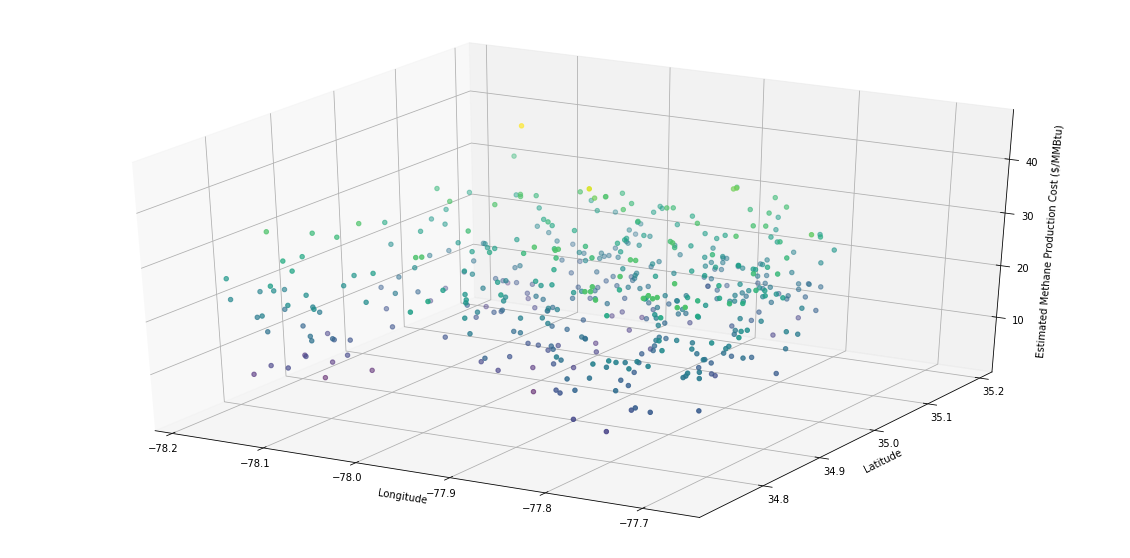

In [103]:
#Build 3d array of base cost values

#Set the axis values
xValues = gdfBG_prj.iloc[:,1] #Longitude
yValues = gdfBG_prj.iloc[:,0] #Latitude
zValues = gdfBG_prj.iloc[:,3] #Production costs 

#Construct the figure
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xValues,yValues,zValues,c=zValues);
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Estimated Methane Production Cost ($/MMBtu)");

In [104]:
#Create a 3 point for the lowest cost site
X1,Y1,Z1 = gdfBG_prj.iloc[0,[-2,-1,3]].values

In [105]:
#Create a mesh grid from the row and column
y = np.arange(0,arrMin.shape[0])
x = np.arange(0,arrMin.shape[1])
X,Y  = np.meshgrid(x,y)

#Create copies of the arrMin surface
arrMinCopy = arrMin.copy()
arrMinCopy[arrMin < 0]=np.NaN
arrMinCopy[arrMin > 5]=np.NaN
arrThreshold = np.full(arrMinCopy.shape,3)

C:\Users\jpfay\AppData\Local\ESRI\conda\envs\bg_optimi\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


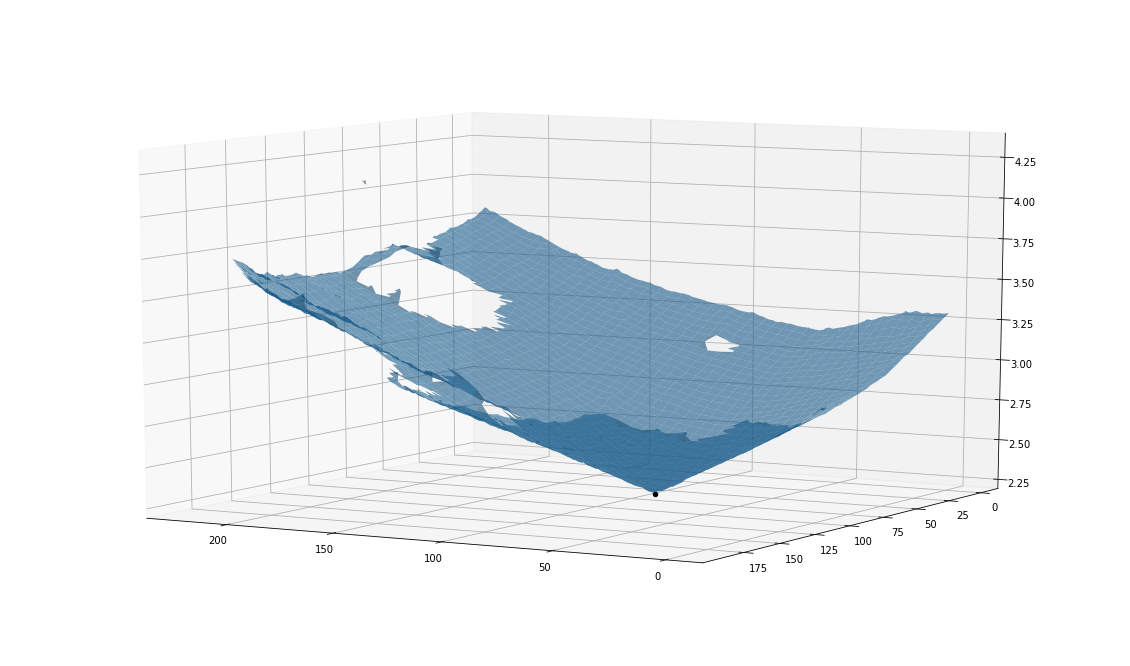

In [108]:
#3D plotting
fig = plt.figure(figsize=(20,12))            #Create the figure canvas
ax = fig.add_subplot(111, projection='3d')   #Add 3d plot...

#ax.contour3D(X,Y,arrMinCopy,100,alpha=0.2,cmap='ocean')
ax.plot_surface(X,Y,arrMinCopy,linewidth=0,alpha=0.6)
#ax.plot_surface(X,Y,arrThreshold,linewidth=0,alpha=0.3)
#ax.scatter3D(X1m,Y1m,np.log(Z1),color='r')
#ax.scatter3D(X1,Y1,Z1,color='y')
#ax.scatter3D(gdfBG_prj.iloc[:,-2],gdfBG_prj.iloc[:,-1],gdfBG_prj.iloc[:,3], c=gdfBG_prj.iloc[:,3],cmap='Greens');
#ax.scatter3D(gdf.xOffset,dfBG.yOffset,dfBG['Estimated Methane Production Cost ($/MMBtu)'], cmap='ocean')
ax.scatter3D(gdfBG_prj.iloc[0,-2],gdfBG_prj.iloc[0,-1],gdfBG_prj.iloc[0,3], color='k')

ax.view_init(10,120);